In [51]:
from typing import TypedDict, Annotated
from dotenv import load_dotenv
from time import sleep
from rich.console import Console
from rich.markdown import Markdown

from langchain.chat_models import init_chat_model
from langchain_core.tools import tool

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

In [52]:
load_dotenv()
console = Console()

In [53]:
@tool
def get_stock_price(symbol: str) -> float:
    """return the current stock price give stock symbol
    :param symbol (str): Stock ticker symbol, e.g. 'MSFT' for Microsoft.
    :return: Current stock price as a float.
    """
    # dummy code, replace with actual implementation
    return {
        "MSFT": 200.3,
        "AAPL": 100.4,
        "AMZN": 150.0,
        "RIL": 87.6,
    }.get(symbol, 0.0)


tools = [get_stock_price]

In [54]:
llm = init_chat_model("google_genai:gemini-2.5-flash", temperature=0.0)
# bind llm with tools
llm_with_tools = llm.bind_tools(tools)

In [55]:
class State(TypedDict):
    messages: Annotated[list, add_messages]


def chatbot(state: State) -> State:
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

In [56]:
# build our graph
builder = StateGraph(State)
builder.add_node("chatbot", chatbot)
builder.add_node("tools", ToolNode(tools))
# build edges: START -> chatbot -> END
builder.add_edge(START, "chatbot")
builder.add_conditional_edges("chatbot", tools_condition)
# loop back to chatbot from tools node
builder.add_edge("tools", "chatbot")
builder.add_edge("chatbot", END)
graph = builder.compile()

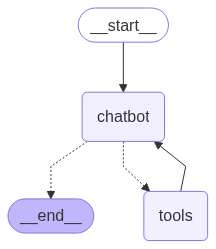

In [57]:
# display the graph
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [58]:
def run_chatbot(prompt: str) -> str:
    message = {"role": "user", "content": prompt}
    response = graph.invoke({"messages": [message]})
    return response["messages"][-1].content

In [59]:
# here we expect the graph to run via the tools path
# (inspecty response variable in your IDE - it should show too call(s))
prompt: str = "What is the latest price for AMZN stock? Return just the price."
message = {"role": "user", "content": prompt}
response = graph.invoke({"messages": [message]})
# console.print(run_chatbot(prompt), style="green")
console.print(response["messages"][-1].content, style="cyan")
console.print(response["messages"])
# deliberate call to prevent rate limit errors
sleep(1)

150

[
    HumanMessage(
        content='What is the latest price for AMZN stock? Return just the price.',
        additional_kwargs={},
        response_metadata={},
        id='7cff49fc-c2ad-4115-bd03-da8dc7315a43'
    ),
    AIMessage(
        content='',
        additional_kwargs={'function_call': {'name': 'get_stock_price', 'arguments': '{"symbol": "AMZN"}'}},
        response_metadata={
            'prompt_feedback': {'block_reason': 0, 'safety_ratings': []},
            'finish_reason': 'STOP',
            'safety_ratings': []
        },
        id='run--32b62d9a-4acc-4c51-b9cd-83b91e88261e-0',
        tool_calls=[
            {
                'name': 'get_stock_price',
                'args': {'symbol': 'AMZN'},
                'id': '5285444a-7154-40b0-9859-8416d808dadd',
                'type': 'tool_call'
            }
        ],
        usage_metadata={
            'input_tokens': 93,
            'output_tokens': 18,
            'total_tokens': 191,
            'input_token_details': {'cache_read': 0}
        }
    ),
    ToolMessage(
        content='150.0',
        name='get_stock_price',
        id='d995592d-b950-4a66-a3d9-cfe1b25e6452',
        tool_call_id='5285444a-7154-40b0-9859-8416d808dadd'
    ),
    AIMessage(
        content='150',
        additional_kwargs={},
        response_metadata={
            'prompt_feedback': {'block_reason': 0, 'safety_ratings': []},
            'finish_reason': 'STOP',
            'safety_ratings': []
        },
        id='run--4d798c33-d287-4030-b5f1-2c25c3f0a8cc-0',
        usage_metadata={
            'input_tokens': 130,
            'output_tokens': 3,
            'total_tokens': 133,
            'input_token_details': {'cache_read': 0}
        }
    )
]

In [60]:
# here we DON'T expect the graph to run via the tools path
# (inspecty response variable in your IDE - it should NOT show a tool call)
prompt: str = "Who discovered penicillin? Return just a name."
message = {"role": "user", "content": prompt}
response = graph.invoke({"messages": [message]})
# console.print(run_chatbot(prompt), style="green")
console.print(response["messages"][-1].content, style="cyan")
console.print(response["messages"])
sleep(1)

Alexander Fleming

[
    HumanMessage(
        content='Who discovered penicillin? Return just a name.',
        additional_kwargs={},
        response_metadata={},
        id='e51b4a46-89aa-4763-beca-47fb5a7c158c'
    ),
    AIMessage(
        content='Alexander Fleming',
        additional_kwargs={},
        response_metadata={
            'prompt_feedback': {'block_reason': 0, 'safety_ratings': []},
            'finish_reason': 'STOP',
            'safety_ratings': []
        },
        id='run--44ae162b-07f6-4606-bdc4-d6746e42ed77-0',
        usage_metadata={
            'input_tokens': 87,
            'output_tokens': 2,
            'total_tokens': 89,
            'input_token_details': {'cache_read': 0}
        }
    )
]

In [61]:
# what if I ask a combined question like this, will the graph work?
prompt: str = (
    "If I buy 10 shares of MSFT and 12 of AAPL, what is the total value of my portfolio? Show me your reasoning"
)
message = {"role": "user", "content": prompt}
response = graph.invoke({"messages": [message]})
console.print(Markdown(run_chatbot(prompt)), style="yellow")
console.print(response["messages"])
sleep(1)

Here's the breakdown of your portfolio's value:                                                                    

 • MSFT: 10 shares * $200.30/share = $2003.00                                                                      
 • AAPL: 12 shares * $100.40/share = $1204.80                                                                      

Total Portfolio Value: $2003.00 + $1204.80 = $3207.80                                                              

[
    HumanMessage(
        content='If I buy 10 shares of MSFT and 12 of AAPL, what is the total value of my portfolio? Show me your 
reasoning',
        additional_kwargs={},
        response_metadata={},
        id='fc95c420-d620-4a65-8b4b-8f3b59ba4748'
    ),
    AIMessage(
        content='',
        additional_kwargs={'function_call': {'name': 'get_stock_price', 'arguments': '{"symbol": "MSFT"}'}},
        response_metadata={
            'prompt_feedback': {'block_reason': 0, 'safety_ratings': []},
            'finish_reason': 'STOP',
            'safety_ratings': []
        },
        id='run--1d99cb41-cdb5-479c-9738-eaae41ae6297-0',
        tool_calls=[
            {
                'name': 'get_stock_price',
                'args': {'symbol': 'MSFT'},
                'id': 'aee5a523-ac8f-4e24-a025-916f9831f974',
                'type': 'tool_call'
            }
        ],
        usage_metadata={
            'input_tokens': 109,
            'output_tokens': 18,
            'total_tokens': 245,
            'input_token_details': {'cache_read': 0}
        }
    ),
    ToolMessage(
        content='200.3',
        name='get_stock_price',
        id='03de4664-b3c7-4e8e-b18d-9553f402dd29',
        tool_call_id='aee5a523-ac8f-4e24-a025-916f9831f974'
    ),
    AIMessage(
        content='',
        additional_kwargs={'function_call': {'name': 'get_stock_price', 'arguments': '{"symbol": "AAPL"}'}},
        response_metadata={
            'prompt_feedback': {'block_reason': 0, 'safety_ratings': []},
            'finish_reason': 'STOP',
            'safety_ratings': []
        },
        id='run--64b77611-0e70-4622-9c8c-19e290088531-0',
        tool_calls=[
            {
                'name': 'get_stock_price',
                'args': {'symbol': 'AAPL'},
                'id': '2a38bb74-9a5b-4885-95b9-fc0fc8a64a12',
                'type': 'tool_call'
            }
        ],
        usage_metadata={
            'input_tokens': 148,
            'output_tokens': 17,
            'total_tokens': 279,
            'input_token_details': {'cache_read': 0}
        }
    ),
    ToolMessage(
        content='100.4',
        name='get_stock_price',
        id='015ffdec-e7c4-429c-a4de-8cb34d6abd2c',
        tool_call_id='2a38bb74-9a5b-4885-95b9-fc0fc8a64a12'
    ),
    AIMessage(
        content="Here's the breakdown of your portfolio's value:\n\n*   **MSFT:** 10 shares * $200.30/share = 
$2003.00\n*   **AAPL:** 12 shares * $100.40/share = $1204.80\n\n**Total Portfolio Value:** $2003.00 + $1204.80 = 
**$3207.80**",
        additional_kwargs={},
        response_metadata={
            'prompt_feedback': {'block_reason': 0, 'safety_ratings': []},
            'finish_reason': 'STOP',
            'safety_ratings': []
        },
        id='run--f90c1c27-b8b1-4e45-9b6c-dd5a5ae22234-0',
        usage_metadata={
            'input_tokens': 186,
            'output_tokens': 105,
            'total_tokens': 513,
            'input_token_details': {'cache_read': 0}
        }
    )
]

Notice that the LLM is now able to reason & calculate the total investment due to the loopback from the tools to the LLM.

However, the LLM won't be able to handle a query like the following, which refers to the _output_ from the previous queries. To enable that, we'll need to provide LLM with memory, which is what we'll do in the next notebook.

In [63]:
# this question will not work!
prompt: str = (
    "With my total portfolio value, how many shares of RIL can I buy? Show me your reasoning"
)
message = {"role": "user", "content": prompt}
response = graph.invoke({"messages": [message]})
console.print(Markdown(run_chatbot(prompt)), style="cyan")
console.print(response["messages"])
sleep(1)

I need to know your total portfolio value to calculate how many shares of RIL you can buy. Once I have that, I will
divide your portfolio value by the current price of RIL shares, which is 87.6.                                     

[
    HumanMessage(
        content='With my total portfolio value, how many shares of RIL can I buy? Show me your reasoning',
        additional_kwargs={},
        response_metadata={},
        id='8cf0f1e8-3f70-4790-a7a7-55763f8c30ee'
    ),
    AIMessage(
        content='I need to know your total portfolio value to calculate how many shares of RIL you can buy. I will 
also need to fetch the current stock price of RIL.',
        additional_kwargs={'function_call': {'name': 'get_stock_price', 'arguments': '{"symbol": "RIL"}'}},
        response_metadata={
            'prompt_feedback': {'block_reason': 0, 'safety_ratings': []},
            'finish_reason': 'STOP',
            'safety_ratings': []
        },
        id='run--9275fca7-6986-4390-920f-ac0bd3be6da3-0',
        tool_calls=[
            {
                'name': 'get_stock_price',
                'args': {'symbol': 'RIL'},
                'id': '0290c8dd-c95f-4d95-abee-34595627e46d',
                'type': 'tool_call'
            }
        ],
        usage_metadata={
            'input_tokens': 98,
            'output_tokens': 53,
            'total_tokens': 319,
            'input_token_details': {'cache_read': 0}
        }
    ),
    ToolMessage(
        content='87.6',
        name='get_stock_price',
        id='387ab761-9402-4ed6-a374-0105694ba9c8',
        tool_call_id='0290c8dd-c95f-4d95-abee-34595627e46d'
    ),
    AIMessage(
        content='I need to know your total portfolio value to calculate how many shares of RIL you can buy. Once I 
have that, I will divide your portfolio value by the current price of RIL shares, which is 87.6.',
        additional_kwargs={},
        response_metadata={
            'prompt_feedback': {'block_reason': 0, 'safety_ratings': []},
            'finish_reason': 'STOP',
            'safety_ratings': []
        },
        id='run--5f93ab11-1772-4c80-9766-bc57af2e9488-0',
        usage_metadata={
            'input_tokens': 136,
            'output_tokens': 48,
            'total_tokens': 184,
            'input_token_details': {'cache_read': 0}
        }
    )
]